In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

In [ ]:
# Read data from csv file, consider column 'date' as index and parse it into date object
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [ ]:
# Selecting training_set from begining of 2015 till end of 2017, we can do this because our index in date object
# and selecting test_set from begining of 2018 onwards
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

# Normalize each symbols independently

In [ ]:
symbols = trainSet.ticker.unique()

In [44]:
timesteps = 60
x_train = {1:[], 3:[], 5:[], 10:[]}
y_train = {1:[], 3:[], 5:[], 10:[]}
scaler = {}
for s in symbols:
    sc = MinMaxScaler(feature_range=(0,1))
    stop_append = {3: False, 5: False, 10: False}
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    sc.partial_fit(train_stock)
    sc.partial_fit(test_stock)
    train_stock_scaled = sc.transform(train_stock)
    test_stock_scaled = sc.transform(test_stock)
    scaler[s] = sc
    l = len(train_stock_scaled)
    for i in range(timesteps, l):
        x = train_stock_scaled[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                k = train_stock_scaled[i+j-1,0]
                x_train[j].append(x)
                y_train[j].append(k)
                if k == train_stock_scaled[l-1,0]:
                    stop_append[j] =True
        x_train[1].append(x)
        y_train[1].append(train_stock_scaled[i,0])
    if s== 'AAPL':
        break
for i in x_train:
    x_train[i] = np.array(x_train[i])
    y_train[i] = np.array(y_train[i])

In [39]:
# Callback function `earlystopping` to trigger while training it monitor 'loss'
# start from first epoch it record min value of loss and if model can not find 
# lower loss value in next 3 epochs model will stop training.
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=2, mode='min')

In [68]:
# The GRU architecture
# We are using Sequential model of Keras
# Our hidden layer using activation = 'tanh' and having 50 neurons each layer
# The output layer of fully connected layer is having only 1 neurons because we want only one output value
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
#     # Second GRU layer
#     regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
#     regressorGRU.add(Dropout(0.2))
#     # Third GRU layer
#     regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
#     regressorGRU.add(Dropout(0.2))
#     # Fourth GRU layer
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [69]:
prediction_intervals = [1,3,5,10]
model = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    n_epoch = 10
    X_train = x_train[i]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    Y_train = y_train[i]
    print('Fitting prediction interval {}  model'.format(i))
    model[i].fit(X_train, 
                 Y_train,
                 epochs = n_epoch, 
                 batch_size = len(Y_train) // n_epoch, 
                 validation_split = 0.2,callbacks=[es])

Fitting prediction interval 1  model
Train on 5512 samples, validate on 1378 samples
Epoch 1/10
5512/5512 [==============================] - 7s 1ms/step - loss: 0.0270 - val_loss: 0.0025
Epoch 2/10
5512/5512 [==============================] - 2s 294us/step - loss: 0.0050 - val_loss: 0.0012
Epoch 3/10
5512/5512 [==============================] - 2s 282us/step - loss: 0.0056 - val_loss: 0.0029
Epoch 4/10
5512/5512 [==============================] - 2s 285us/step - loss: 0.0041 - val_loss: 0.0011
Epoch 5/10
5512/5512 [==============================] - 2s 284us/step - loss: 0.0054 - val_loss: 0.0022
Epoch 6/10
5512/5512 [==============================] - 2s 282us/step - loss: 0.0041 - val_loss: 0.0014
Fitting prediction interval 3  model
Train on 5389 samples, validate on 1348 samples
Epoch 1/10
5389/5389 [==============================] - 7s 1ms/step - loss: 0.0629 - val_loss: 0.0079
Epoch 2/10
5389/5389 [==============================] - 2s 334us/step - loss: 0.0086 - val_loss: 0.0064
Ep

## Helper function ##

In [70]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [71]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Evaluate model #

In [72]:
s = 'A'
sc = scaler[s]
a_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values
a_stock_scaled = sc.transform(a_stock)

In [73]:
x_test = {1:[], 3:[], 5:[], 10:[]}
y_test = {1:[], 3:[], 5:[], 10:[]}
stop_append = {3: False, 5: False, 10: False}
l = len(a_stock_scaled)
for i in range(timesteps, l):
    x = a_stock_scaled[i-timesteps: i, 0]
    for j in stop_append:
        if not stop_append[j]:
            k = a_stock_scaled[i+j-1,0]
            x_test[j].append(x)
            y_test[j].append(k)
            if k == a_stock_scaled[l-1,0]:
                stop_append[j] =True
    x_test[1].append(x)
    y_test[1].append(a_stock_scaled[i,0])
for i in x_test:
    x_test[i] = np.array(x_test[i])
    y_test[i] = np.array(y_test[i])

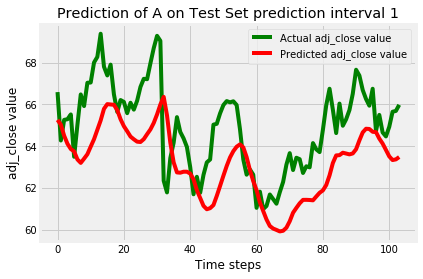

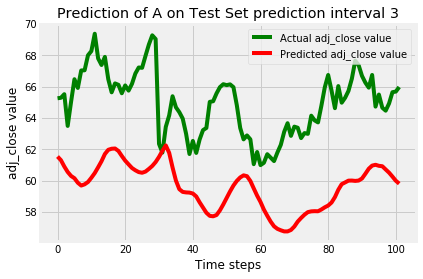

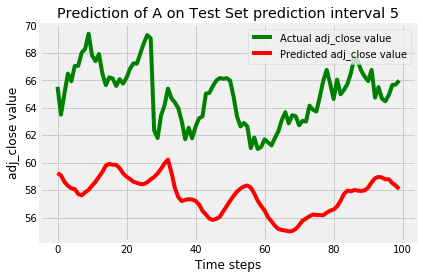

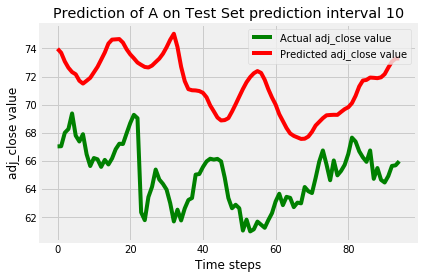

In [76]:
mse_val = {}
for i in prediction_intervals:
    X_train = x_test[i]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    Y_train = y_test[i]
    Y_train = Y_train.reshape(-1,1)
    y_true = sc.inverse_transform(Y_train)
    
    result = model[i].predict(X_train)
    y_pred = sc.inverse_transform(result)
    mse_val[i] = return_mse(y_true, y_pred)
    plotting_graph(y_true, y_pred, s, 'Test Set prediction interval {}'.format(i))

In [77]:
for i in mse_val:
    print('MSE of prediction inveral = {}: {}'.format(i, mse_val[i]))

MSE of prediction inveral = 1: 4.993348008420615
MSE of prediction inveral = 3: 31.2956714046549
MSE of prediction inveral = 5: 56.926796839718214
MSE of prediction inveral = 10: 48.60800958875572
